An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


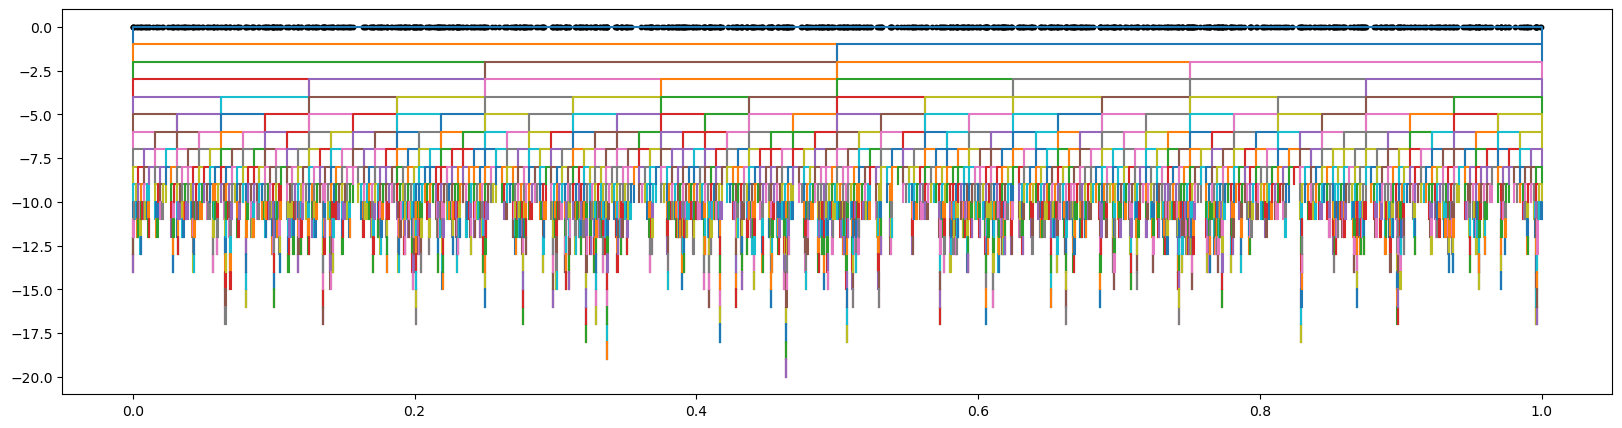

In [1]:
import sys
sys.path.append('../')

import jax
from jax import vmap
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from trees import get_1d_tree, get_data_1d, plot_1d_tree, is_far, iF
from trees import flatten_around_point, get_features, plot_1d_tree, data_plotter
from trees import potential_from_features, potential_from_points, potential_from_feature

# Example usage
key = jax.random.PRNGKey(0)
N = 1000
max_points = 1
center_x, width = 0.5, 1.0

i = np.arange(N)
x = jax.random.uniform(key, (N,), minval=center_x-width/2, maxval=center_x+width/2)
tree_1d = get_1d_tree(i, x, center_x, width, max_points=max_points, data_func=get_data_1d)

plt.figure(figsize=(20, 5))
plot_1d_tree(tree_1d, depth=0, data_plotter=None)
plt.scatter(x, np.zeros_like(x), color='black', s=10)


(-0.05, 1.05, -2.1, 0.1)

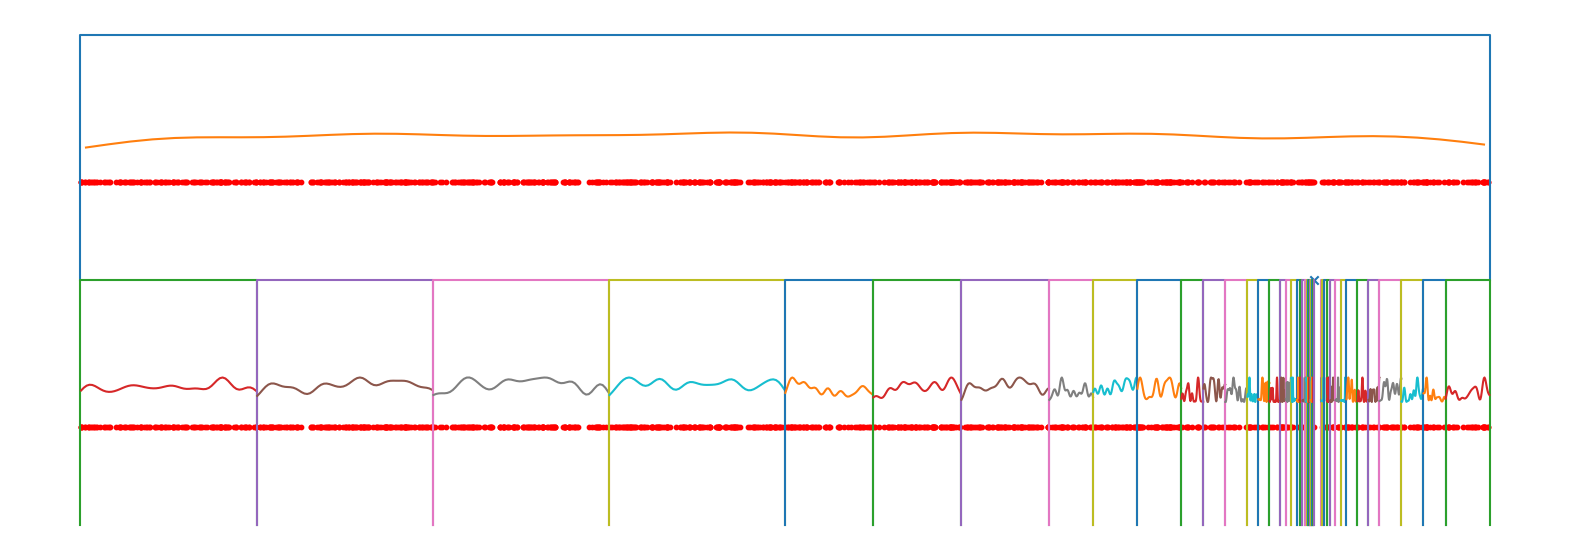

In [2]:

ratio = 0.3
x0 = x[10]#0.2
new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
new_leavy_tree_1d = {"children": new_leaves_1d, "data": tree_1d["data"]}
x0_features = get_features(new_leaves_1d)

plt.figure(figsize=(20, 7))
plot_1d_tree(new_leavy_tree_1d, data_plotter=data_plotter)
plt.scatter([x0], [-1], marker='x')
plt.axis("off")

In [3]:

training_data = []
for x0 in x:
    new_leaves_1d = flatten_around_point(x0, ratio, tree_1d)
    new_leaves_1d = [leaf for leaf in new_leaves_1d if is_far(leaf, x0, ratio)]
    x0_features = get_features(new_leaves_1d)
    x0_features = x0_features.at[:,-2].set(x0_features[:,-2] - x0)
    
    val = potential_from_points(x0, x) / len(x)
    fmm_val = potential_from_features(0., x0_features) / len(x)
    print(f"True value: {val:.2f}, FMM value: {fmm_val:.2f}, Rel. Error: {jnp.abs(val - fmm_val)/jnp.abs(val):.2e} ===========", end='\r')
    training_data.append((x0_features, val))   

In [4]:
# Scaling for data structure:
# Depth 0: order N
# Depth 1: order N because 2 intervals w. N/2 points
# ...
# Depth log(N): order N bcs. N intervals w. 1 point
# => O(N log N) data structure

Far field contribution = 28 %


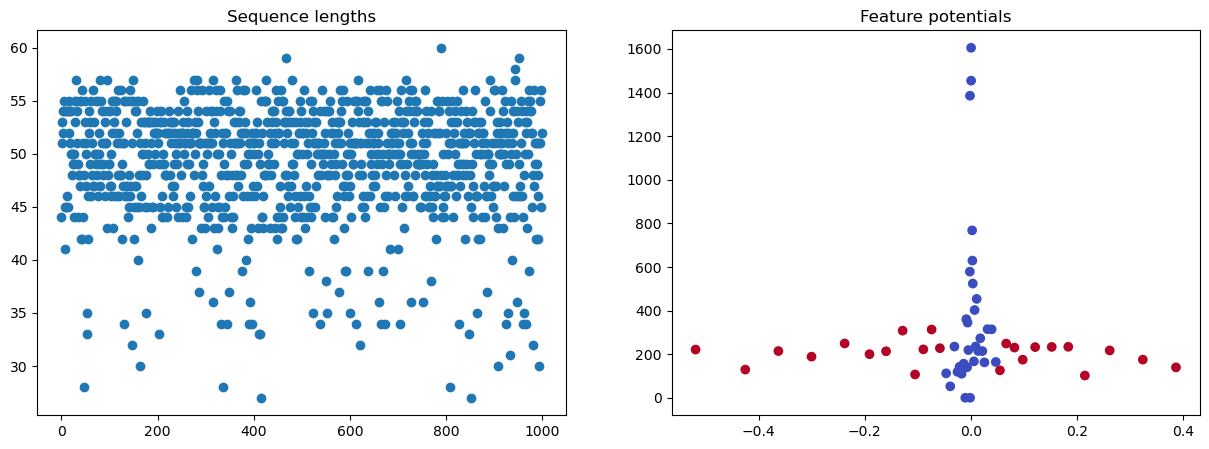

In [5]:
idx_test = 20
far_dist = 0.05
feature_positions = jnp.array([d[-2].real for d in training_data[idx_test][0]])
feature_potentials = jnp.array([potential_from_feature(0, d).real for d in training_data[idx_test][0]])
far_field = jnp.sum(jnp.where(jnp.abs(feature_positions) > far_dist, feature_potentials, 0.))

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Sequence lengths")
plt.scatter(list(range(len(training_data))), [dat[0].shape[0] for dat in training_data])

plt.subplot(122)
plt.title("Feature potentials")
plt.scatter(feature_positions, feature_potentials, c=jnp.abs(feature_positions)>far_dist, cmap='coolwarm')
print(f"Far field contribution = {far_field/jnp.sum(feature_potentials)*100:.0f} %")    